In [2]:
import torch
import sys
import numpy as np

sys.path.append(r'/user/gr1/delphi/dghezzi/UNet')

from UNet import UNet, UNetWithAttention

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Crea istanza modello (deve avere la stessa architettura usata in training)
model = UNetWithAttention(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("best_unet_for_val_loss.pth", map_location=device))
model.to(device)
model.eval()  # modalità valutazione (disabilita dropout, batchnorm, ecc)


UNetWithAttention(
  (encoder1): DoubleConv(
    (block): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): DoubleConv(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(i

In [3]:
import cv2
import torch
from torchvision import transforms

img_path = "/user/gr1/delphi/dghezzi/UNet/Models/prova.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # carica in scala di grigi
img = cv2.resize(img, (800, 800))
img = img.astype('float32') / 255.0  # normalizza
img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)  # [H,W] -> [1,C,H,W] con C=1

img_tensor = img_tensor.to(device)
with torch.no_grad():
    output = model(img_tensor)  # shape: [1, out_channels, 800, 800]

# Se out_channels=1, output è la heatmap predetta
heatmap_pred = output.squeeze().cpu().numpy()  # [800, 800]

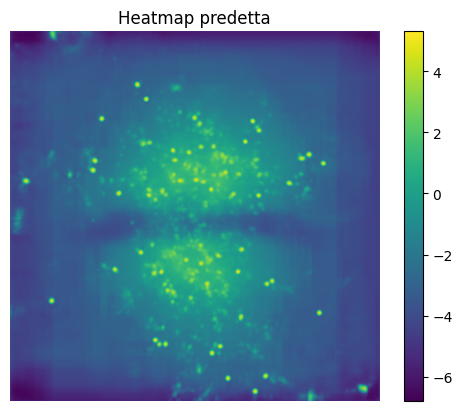

(800, 800)
Min: -6.7933226
Max: 5.30479
Mean: -2.7113874
[[-5.0779777 -4.9756074 -5.1727166 ... -5.3396435 -5.0759225 -5.069506 ]
 [-4.8213177 -5.1448617 -5.28278   ... -5.4610023 -5.0931325 -4.9479904]
 [-4.681248  -5.0706215 -5.434876  ... -5.5322337 -5.1245933 -4.9888844]
 ...
 [-4.8594265 -5.2568808 -5.556728  ... -5.470182  -5.1415324 -4.865002 ]
 [-4.887491  -5.1156344 -5.476357  ... -5.2877717 -4.942261  -4.6877046]
 [-5.3226657 -5.3504834 -5.5958776 ... -5.4495435 -5.059731  -5.1333766]]


In [4]:
import matplotlib.pyplot as plt

plt.imshow(heatmap_pred)
plt.title("Heatmap predetta")
plt.colorbar()
plt.axis('off')
plt.show()
plt.imsave("heatmap_predetta.png", heatmap_pred)

print(heatmap_pred.shape)
print("Min:", heatmap_pred.min())
print("Max:", heatmap_pred.max())
print("Mean:", heatmap_pred.mean())
print(heatmap_pred)

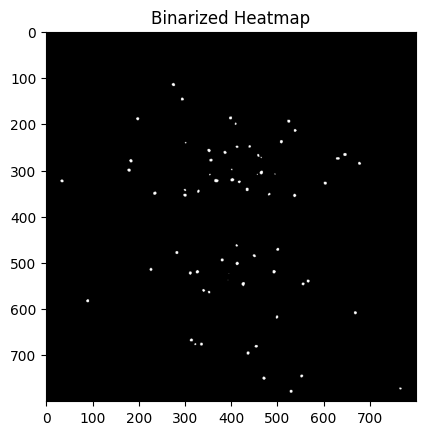

[[275, 115], [294, 147], [399, 187], [198, 189], [524, 194], [410, 200], [538, 214], [508, 239], [302, 241], [440, 249], [413, 250], [352, 258], [387, 262], [646, 266], [459, 268], [465, 273], [630, 275], [183, 280], [356, 279], [677, 286], [179, 300], [401, 299], [465, 305], [354, 310], [456, 310], [495, 309], [402, 321], [34, 324], [368, 323], [417, 326], [603, 328], [434, 342], [300, 343], [329, 346], [235, 350], [482, 352], [300, 354], [537, 355], [412, 463], [501, 472], [282, 478], [450, 485], [380, 494], [413, 502], [226, 515], [327, 520], [493, 520], [312, 523], [395, 524], [566, 540], [393, 538], [426, 546], [555, 546], [340, 560], [352, 564], [90, 583], [668, 609], [499, 618], [314, 668], [322, 677], [336, 676], [454, 681], [436, 696], [552, 745], [471, 750], [766, 772], [530, 778]]
Numero di keypoints estratti: 67


In [4]:
from UNet import extract_predicted_keypoints

keypoints = extract_predicted_keypoints(heatmap_pred, threshold=heatmap_pred.max()-2, show_mask=True)
print(keypoints)
print(f"Numero di keypoints estratti: {len(keypoints)}")

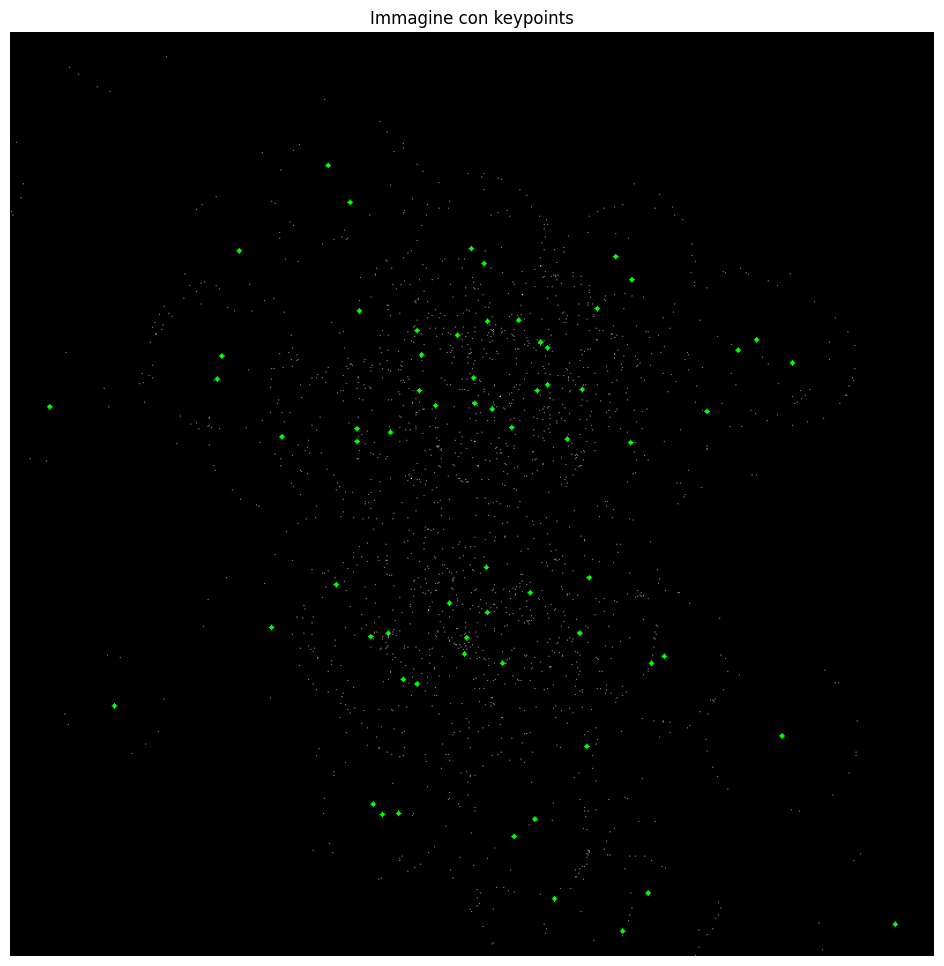

In [5]:
# Normalizza immagine originale a uint8 (0-255)
img_norm = img - img.min()
img_norm /= img_norm.max()
img_uint8 = (img_norm * 255).astype(np.uint8)

# Resize
img_resized = cv2.resize(img_uint8, (800, 800))
img_with_keypoints = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)


# Disegna i keypoints
for (x, y) in keypoints:
    cv2.circle(img_with_keypoints, (x, y), 2, (0, 255, 0), -1)

# Salva e mostra
cv2.imwrite("inference.png", img_with_keypoints)

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Immagine con keypoints")
plt.show()

In [6]:
from UNet import compute_pck_metrics
import pandas as pd

df = pd.read_csv("/user/gr1/delphi/dghezzi/UNet/Models/prova.csv")
keypoints_gt = df[["x", "y"]].values

pck_metrics = compute_pck_metrics(np.array(keypoints_gt), np.array(keypoints), thresholds=np.arange(1, 10, 1))
for t, (p, r, f1) in zip(np.arange(1, 10, 1), zip(*pck_metrics)):
    print(f"Threshold {t}px: Precision={p:.4f}, Recall={r:.4f}, F1-score={f1:.4f}")

Threshold 1px: Precision=0.1791, Recall=0.0706, F1-score=0.1013
Threshold 2px: Precision=0.6567, Recall=0.2588, F1-score=0.3713
Threshold 3px: Precision=0.8060, Recall=0.3176, F1-score=0.4557
Threshold 4px: Precision=0.8806, Recall=0.3471, F1-score=0.4979
Threshold 5px: Precision=0.8955, Recall=0.3529, F1-score=0.5063
Threshold 6px: Precision=0.8955, Recall=0.3529, F1-score=0.5063
Threshold 7px: Precision=0.8955, Recall=0.3529, F1-score=0.5063
Threshold 8px: Precision=0.9104, Recall=0.3588, F1-score=0.5148
Threshold 9px: Precision=0.9254, Recall=0.3647, F1-score=0.5232


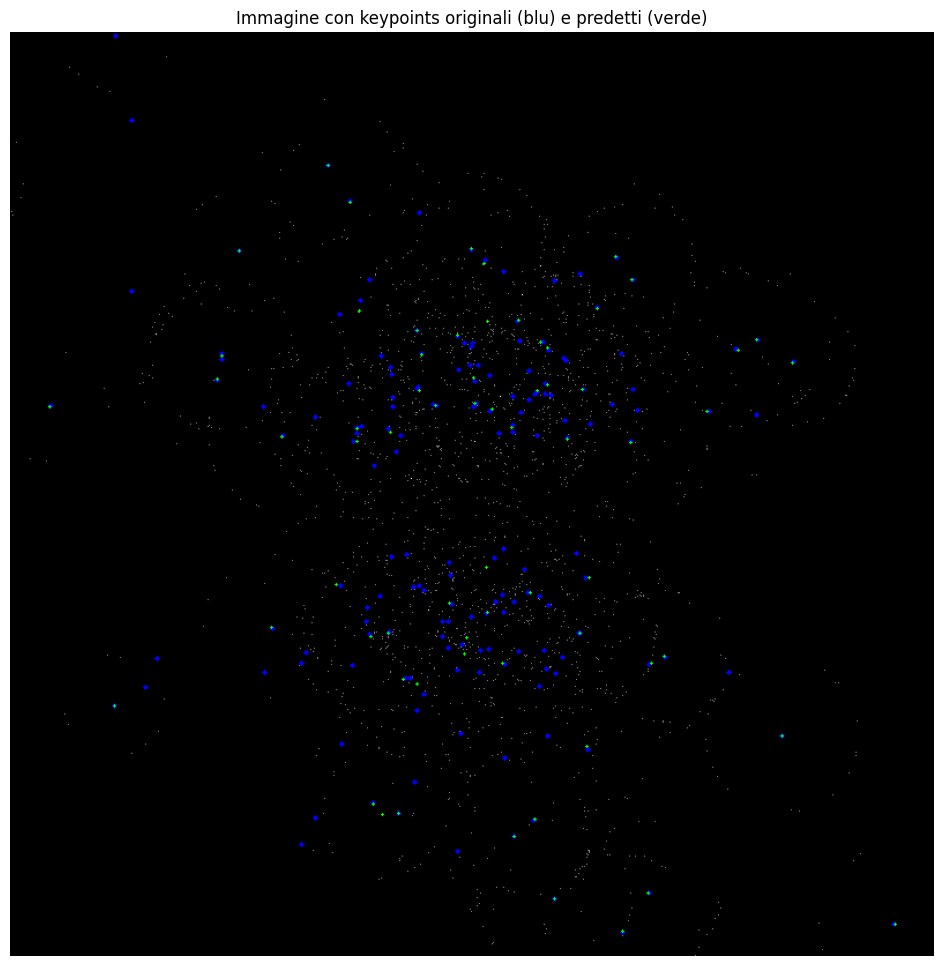

In [7]:
# disegna i keypoints originali e quelli predetti sulla stessa immagine originale
img_with_gt_keypoints = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)
for (x, y) in keypoints_gt:
    cv2.circle(img_with_gt_keypoints, (int(x), int(y)), 2, (255, 0, 0), -1)  # blu per i GT
for (x, y) in keypoints:
    cv2.circle(img_with_gt_keypoints, (x, y), 1, (0, 255, 0), -1)  # verde per i predetti
    
# Salva e mostra l'immagine con i keypoints originali e predetti
cv2.imwrite("inference_with_gt.png", img_with_gt_keypoints)
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(img_with_gt_keypoints, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Immagine con keypoints originali (blu) e predetti (verde)")
plt.show()

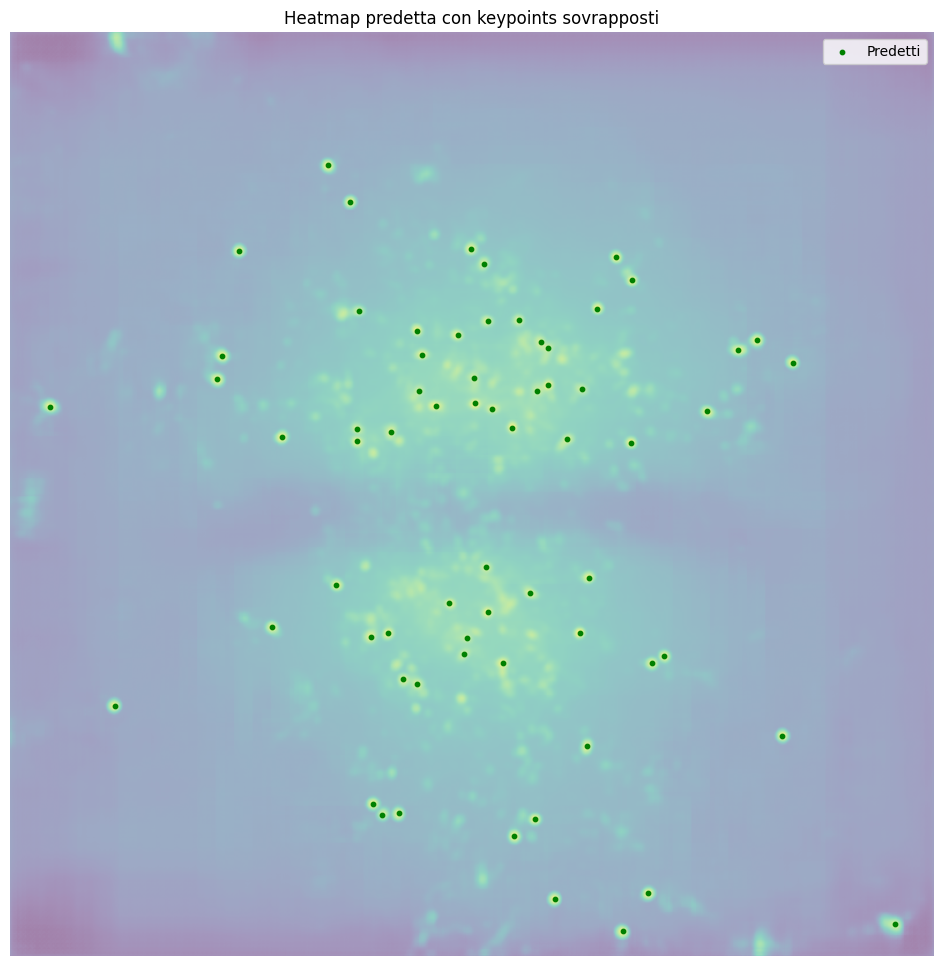

In [8]:
# immagine con heatmap predetta e sovrapposti i keypoints predetti
plt.figure(figsize=(12, 12))
plt.imshow(heatmap_pred, alpha=0.5)  # heatmap con trasparenza
plt.scatter(*zip(*keypoints), color='green', s=10, label='Predetti')
plt.title("Heatmap predetta con keypoints sovrapposti")
plt.axis('off')
plt.legend()
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


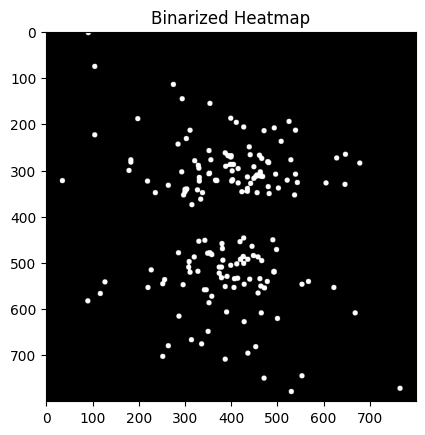

Keypoints GT estratti dalla heatmap: [[91, 4], [105, 76], [275, 115], [294, 146], [354, 156], [399, 188], [198, 189], [525, 195], [411, 197], [427, 207], [493, 209], [311, 214], [539, 214], [471, 215], [105, 224], [303, 232], [508, 238], [285, 244], [439, 250], [352, 258], [394, 268], [647, 266], [441, 267], [464, 272], [628, 274], [183, 280], [356, 278], [529, 278], [326, 288], [480, 283], [678, 285], [397, 289], [449, 293], [415, 297], [179, 301], [402, 302], [293, 304], [447, 325], [352, 308], [496, 309], [539, 309], [331, 320], [435, 315], [368, 322], [402, 322], [521, 322], [35, 323], [219, 324], [415, 328], [543, 327], [605, 328], [646, 331], [264, 333], [480, 336], [502, 339], [300, 347], [332, 346], [236, 349], [456, 349], [482, 351], [537, 354], [334, 363], [315, 375], [423, 451], [343, 452], [490, 451], [330, 454], [380, 464], [445, 465], [498, 472], [286, 479], [354, 481], [457, 490], [320, 488], [424, 496], [382, 495], [309, 510], [399, 506], [376, 510], [227, 516], [328, 5

In [9]:
# prova a computare i keypoint gt da heatmap label e poi confrontali con quelli nel csv
from UNet import extract_predicted_keypoints
heatmap_gt = cv2.imread("/user/gr1/delphi/dghezzi/UNet/Models/prova_heatmap.png", cv2.IMREAD_GRAYSCALE)
heatmap_gt = cv2.resize(heatmap_gt, (800, 800))
print(heatmap_gt)
keypoints_gt = extract_predicted_keypoints(heatmap_gt, threshold=heatmap_gt.min()+1, show_mask=True)
print("Keypoints GT estratti dalla heatmap:", keypoints_gt)

print(heatmap_gt.shape)
print("Min:", heatmap_gt.min())
print("Max:", heatmap_gt.max())
print("Mean:", heatmap_gt.mean())

In [10]:
'''
data_path = '/user/gr1/delphi/dghezzi/UNet/UNet_dataset/5000test'
output_path = '/user/gr1/delphi/dghezzi/UNet/Models/Model_92000_8000_160_180/output_inference'
model_path = '/user/gr1/delphi/dghezzi/UNet/Models/Model_92000_8000_160_180/best_unet_for_val_loss.pth'
'''

data_path = '/user/gr1/delphi/dghezzi/UNet/UNet_dataset/100'
output_path = '/user/gr1/delphi/dghezzi/UNet/Models/Model_92000_8000_160_180/output_inference100'
model_path = '/user/gr1/delphi/dghezzi/UNet/Models/Model_92000_8000_160_180/best_unet_for_val_loss.pth'

from UNet import inference_dataset

metrics = inference_dataset(
    datapath=data_path,
    output_path=output_path,
    model_path=model_path,
    device=device,
    pixel_thresholds=[2, 4, 6],
    attention_model=True,
    threshold_binary=None,  # None per usare la soglia predefinita del modello  
    show_mask=False  # False per non mostrare le maschere
)

print('Metrics:', metrics)

Metrics: {'precision': [0.20138087063759288, 0.25097662037374524, 0.2737769260370557], 'recall': [0.09071584189128877, 0.11331016718247434, 0.12351932226893611], 'f1': [0.12413775143554817, 0.15494636029660563, 0.16893393034923654], 'inference_time': 0.003994348256484322}
